## Getting data throw kaggle API

First of all, we need to create an account on Kaggle.com to download the data for this project.  
Kaggle.com is a web that hosts a lot of public datasets and also makes competitions and data science challenges.  
  
Once we have created our account, we need to go to the competition page and click on "join the competition" to accept the terms and conditions of getting datasets:  
![Alt text](./.images/joinCompetition.png)  

After that, we can go to Account (settings) and click on "Create New API Token"  
![Alt text](./.images/apiToken.png)  

This will download a json file that we need in the next step to get the dataset. It will be easier if we move it now to the main folder of this project.

In [36]:
%%capture
import os
from os import path
!pip install --upgrade --force-reinstall --no-deps kaggle
!pip install --force-reinstall unzip

!mkdir .kaggle

#once you have the kaggle.json file in the current directory
!mv ./kaggle.json ./.kaggle/
!chmod 600 ./.kaggle/kaggle.json

path_now = os.getcwd()
os.environ["KAGGLE_CONFIG_DIR"] = path.join(path_now,".kaggle")


In [37]:
%%capture
def cargarDatosKaggle():
    if path.exists('./data/lemon_dataset') == False:
        !kaggle datasets download -d yusufemir/lemon-quality-dataset
        !mkdir data
        !unzip lemon-quality-dataset -d data
        !rm -r lemon-quality-dataset.zip
        !rm -r data/lemon_dataset/.git/
        print('Data downloaded and unziped in data/lemon_dataset')
    else:
        print('\n Data already downloaded in datos/lemon_dataset')

cargarDatosKaggle()

## Inspect the dataset

First, we can count how many lemons and how many classes do we have.

In [38]:
images=[]
def count_images (folder):
    count=0
    for image in os.listdir('./data/lemon_dataset/'+ folder):
        images.append(image)
        count+=1
    return count
    
labels=['bad_quality','empty_background','good_quality']
count_bad=count_images("bad_quality")
print(f"Number of images 'bad_quality': {count_bad}")
count_bg=count_images("empty_background")
print(f"Number of images 'empty_background': {count_bg}")
count_good=count_images("good_quality")
print(f"Number of images 'good_quality': {count_good}")
print(f"\nNumber of images: {len(images)}")

Number of images 'bad_quality': 951
Number of images 'empty_background': 452
Number of images 'good_quality': 1125

Number of images: 2528


Now, we choose and show a random image of each set, in order to check the accessibility to every folder

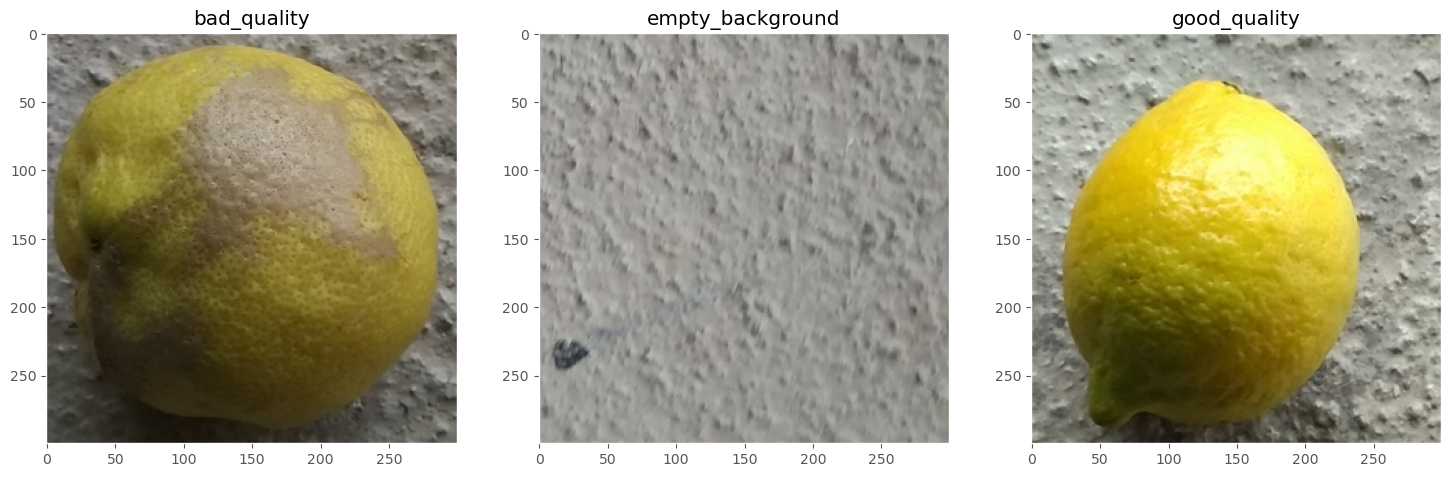

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
fig, ax = plt.subplots(1, 3, figsize=(18, 8))

def show_folder(folder,i):
    idx = np.random.randint(1, 100)
    img = cv2.imread('./data/lemon_dataset/'+folder+'/'+folder+'_'+ str(idx) + '.jpg', cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax[i].set_title(folder)
    ax[i].imshow(img)
    ax[i].grid(False)
    
    
show_folder("bad_quality",0)
show_folder("empty_background",1)
show_folder("good_quality",2)


plt.show()


## Moulding the dataset

We should rescale the images to 96x96, as this is a time-consuming process, we save the result so we can load it directly next time.  
We also save numpy arrays in their original version to save time if we want to use it later.  
Our original images consist of RGB coefficients in the 0-255 range, but such values would be too high for our model to process (given a typical learning rate), so we aimed for values between 0 and 1 by scaling with a 1./255 factor.

In [44]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from os import path
import numpy as np

train_datagen =ImageDataGenerator(rescale=1./255)
#if it doesnt exist rescaled_data folder, we compute and save the rescaled data
if path.exists('./data/rescaled_data') == False:
    os.mkdir('./data/rescaled_data')
    train_lemons= train_datagen.flow_from_directory('./data/lemon_dataset',
        target_size=(96, 96), # Resizes images
        batch_size=len(images), #small dataset, so no problems with RAM 
        class_mode='categorical', #one-hot encoding
        subset = 'training', seed=42)
    X, y = next(train_lemons)
    #save X and y with 96x96 images
    np.save('./data/rescaled_data/X_96',X, allow_pickle=False)
    np.save('./data/rescaled_data/y_96',y, allow_pickle=False)
    print("Resized 96x96 data saved")
if path.exists('./data/original_data') == False:
    os.mkdir('./data/original_data')
    train_lemons_original= train_datagen.flow_from_directory('./data/lemon_dataset',
        batch_size=len(images), #small dataset, so no problems with RAM 
        class_mode='categorical', #one-hot encoding
        subset = 'training', seed=42)
    X_original, y_original = next(train_lemons_original)
    #save X and y with original images
    np.save('./data/original_data/X_original',X_original,allow_pickle=False)
    np.save('./data/original_data/y_original',y_original,allow_pickle=False)
    print("Original data saved")

#direct load of X and y with 96x96 images
X=np.load('./data/rescaled_data/X_96.npy')
y=np.load('./data/rescaled_data/y_96.npy')
print("Resized 96x96 data loaded")
X_original=np.load('./data/original_data/X_original.npy')
y_original=np.load('./data/original_data/y_original.npy')
print("Original data loaded")


Found 2528 images belonging to 3 classes.
Resized 96x96 data saved
Found 2528 images belonging to 3 classes.
Original data saved
Resized 96x96 data loaded
Original data loaded


With the creation of X and y, having the images in different folders by category generates, we import y_train in a way that already has one hot encoding, hence it has 3 columns.

In [45]:
print(f'Shape of y: {y.shape}')
print(f'Shape of X: {X.shape}\n')

print(f'Shape of y_original: {y_original.shape}')
print(f'Shape of X_original: {X_original.shape}')

Shape of y: (2528, 3)
Shape of X: (2528, 96, 96, 3)

Shape of y_original: (2528, 3)
Shape of X_original: (2528, 256, 256, 3)


We separate the data into data for training "X/y_training" and data for test "X/y_test".  
Then, we separate the training data again into two sets, one for the training itself and one for the training validation "X/y_train" and "X/y_val".

In [46]:
from sklearn.model_selection import train_test_split

X_training, X_test, y_training, y_test = train_test_split( X, y,test_size=0.15,random_state=42)

X_train, X_val, y_train, y_val = train_test_split( X_training, y_training,test_size=0.15,random_state=42)

In [47]:
print('TRAIN DATA')
print(f'Shape of y_train:{y_train.shape}')
print(f'Shape of X_train:{X_train.shape}\n')
print('TEST DATA')
print(f'Shape of y_test:{y_test.shape}')
print(f'Shape of X_test:{X_test.shape}\n')
print('VALIDATION DATA')
print(f'Shape of y_val:{y_val.shape}')
print(f'Shape of X_val:{X_val.shape}')

TRAIN DATA
Shape of y_train:(1825, 3)
Shape of X_train:(1825, 96, 96, 3)

TEST DATA
Shape of y_test:(380, 3)
Shape of X_test:(380, 96, 96, 3)

VALIDATION DATA
Shape of y_val:(323, 3)
Shape of X_val:(323, 96, 96, 3)


We can view examples of the rescaled data that our neural networks will use to learn.

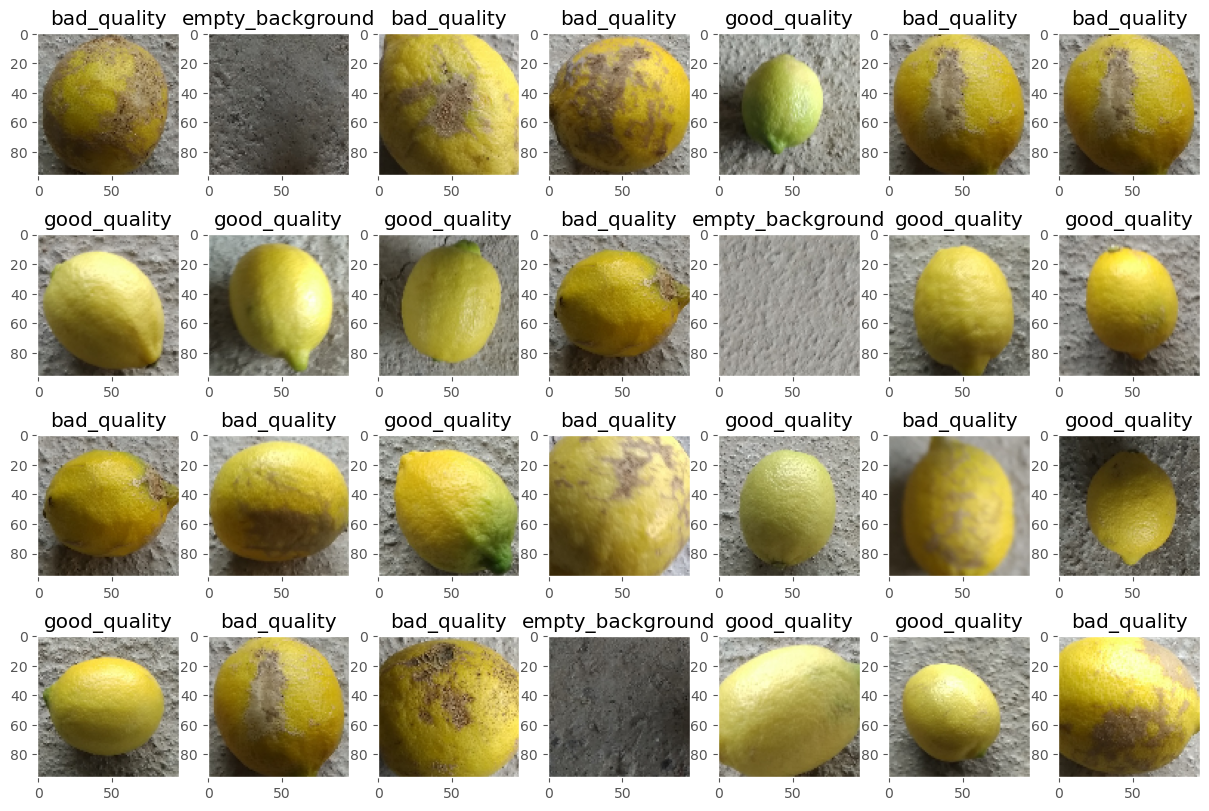

In [48]:
import random
import numpy as np
fig = plt.figure(figsize=(15,10))
for n in range(1, 29):
    fig.add_subplot(4, 7, n)
    ran = random.randint(800,1000)
    img = X_train[ran]
    plt.imshow(img)
    plt.grid(False)
    pos = np.where(y_train[ran]== 1)
    plt.title(labels[int(pos[0])])


## Developing the solution

### From Scratch Strategy

Creation of the model and iterating over it adjusting hyperparameters until we obtain good results.

In [52]:
# Imports
import tensorflow as tf
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,BatchNormalization,Dense

image_shape=(96,96,3)
tf.random.set_seed(42)
model = Sequential()
# 1st conv layer
model.add(Conv2D(256, (3,3), activation='relu', input_shape=image_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(rate=0.2))
#2nd conv layer
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(rate=0.2))
#3rd conv layer
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(rate=0.4))
# Reshape
model.add(Flatten())
# Fully connected Hidden layer
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.4))
# 3 output neurons for the 3 classes
model.add(Dense(3, activation='softmax'))
print("[INFO]: Training...")
opt = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['acc'])
epochs=40 #epochs as a variable to be used when plotting

H1 = model.fit(X_train, y_train,validation_data=(X_val,y_val),epochs=epochs,batch_size=20, verbose=0)
print(model.summary())

[INFO]: Training...
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 94, 94, 256)       7168      
                                                                 
 batch_normalization_29 (Bat  (None, 94, 94, 256)      1024      
 chNormalization)                                                
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 47, 47, 256)      0         
 g2D)                                                            
                                                                 
 dropout_29 (Dropout)        (None, 47, 47, 256)       0         
                                                                 
 conv2d_22 (Conv2D)          (None, 45, 45, 128)       295040    
                                                                 
 batch_normalization_30 (Bat  (Non

We look at the training process to make decisions.  
The aim is that the graph of train/val accuracy is almost 1 (high decision accuracy), while at the same time the validation_loss graph is descending and close to the train_loss graph (to make sure that we do not have overfitting and the classification is reproducible to new data).

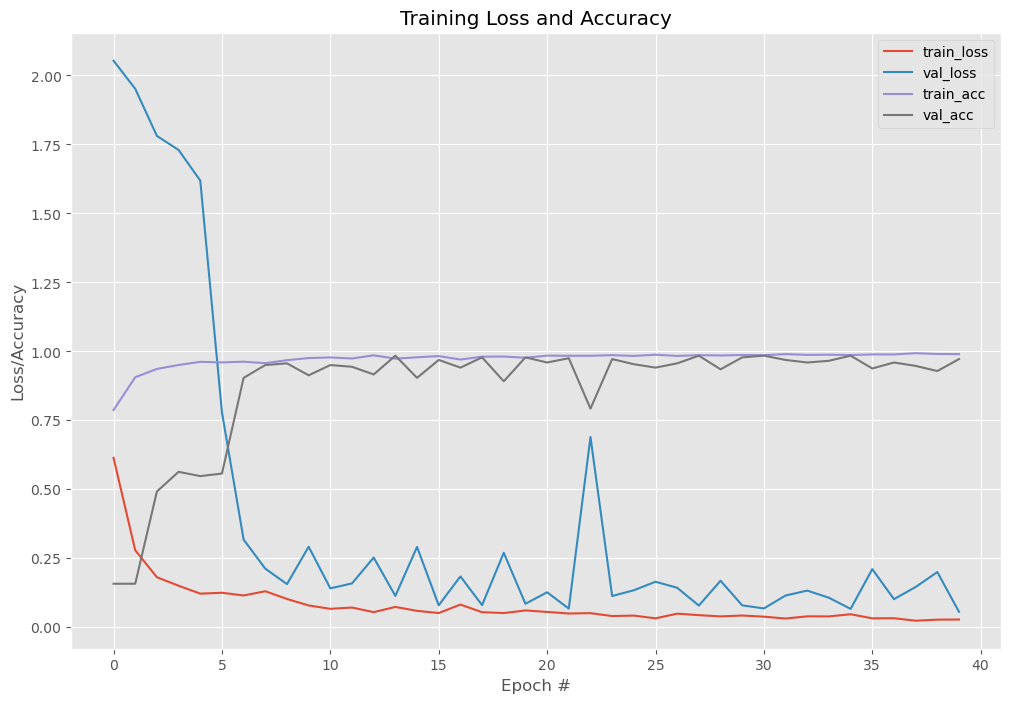

In [53]:
# We show accuracy and losses graphs
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12, 8))
plt.plot(np.arange(0, epochs), H1.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), H1.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epochs), H1.history["acc"], label="train_acc")
plt.plot(np.arange(0, epochs), H1.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

The hyperparameters have been decided on the basis of the following:  
- CNN filter size: (3,3) since according to the state of the art it is the optimal in most cases, we have tested an example with (5.5) and it has given worse results.
- Number of filters (depth) of the CNNs: we have tested values in powers of 2 between 32 and 512 and their combinations in the 3 convolutional layers, finally selecting the combination that obtained the best val_loss and val_acc.
- Batch size: 20 has been selected (approx. 1% of the train size) since our dataset is not excessively large and it will go fast anyway.
- Learning Rate: 0.0001 has been selected, after testing from 0.1 to 0.00001, as this was the value that generated the best results.    
- Activation function: ReLu for the intermediate layers to reduce the computation costs and Softmax in the last layer, since we are in a multi-class classification problem.
- Number of epochs: 40 epochs, since changes with more epochs are already minimal.
- Missing function: 'categorical_crossentropy' is suitable for multi-class classification problems like the one we have, sparse_categorical_crossentropy is not necessary as our data is 'one-hot encoded'

Now, we should evaluate the predictive model and set up the following experimental tests.

In [55]:
predictions = model.predict(X_test,batch_size=128) #(X)
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1),target_names=labels))

3/3 [==============================] - 0s 67ms/step
                  precision    recall  f1-score   support

     bad_quality       1.00      0.97      0.98       159
empty_background       1.00      1.00      1.00        69
    good_quality       0.97      1.00      0.98       152

        accuracy                           0.99       380
       macro avg       0.99      0.99      0.99       380
    weighted avg       0.99      0.99      0.99       380



We see that a very good accuracy is achieved in the differentiation of good and bad quality lemons; probably because the images are easy to differentiate, the good ones have uniform colours while the bad ones have stains and spots.  
When it comes to differentiating between lemons and empty bottom is even simpler for the neural network, achieving 100% accuracy.

In [56]:
# We can save the model for future use
model.save('./data/models/scratch_CNN_96x96.h5')


### Pre-trained network Strategy

The idea now is start from a network that has been pre-trained using large image datasets, so it will have learnt useful patterns for artificial vision (lines, edges, spots, shadows, geometric shapes...).  
We will adapt these pre-trained models to learn the task we are interested in, distinguish lemon quality.

#### From VGG16

##### VGG16 + TRANSFER LEARNING

The idea behind transfer learning is simply to add a prediction layer (softmax) to the already pre-trained network, in this case with weights from ImageNet dataset training.

In [57]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Sequential, layers, Model
from tensorflow.keras.applications import VGG16, imagenet_utils
from tensorflow.keras.applications.vgg16 import preprocess_input

labels=['bad_quality','empty_background','good_quality']

#Applying TRANSFER LEARNING
vgg = VGG16(input_shape=(96,96,3), weights='imagenet', include_top=False)
vgg.trainable = False
x = layers.Flatten()(vgg.output)
prediction = layers.Dense(len(labels), activation='softmax')(x)
model_vgg = Model(inputs=vgg.input, outputs=prediction)
opt = Adam(learning_rate=0.0001)
model_vgg.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['acc'])
epochs=40
H_vgg=model_vgg.fit(X_train, y_train,validation_data=(X_val,y_val),batch_size=20,epochs=epochs,verbose=0)
print(model_vgg.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 24, 24, 128)       0   

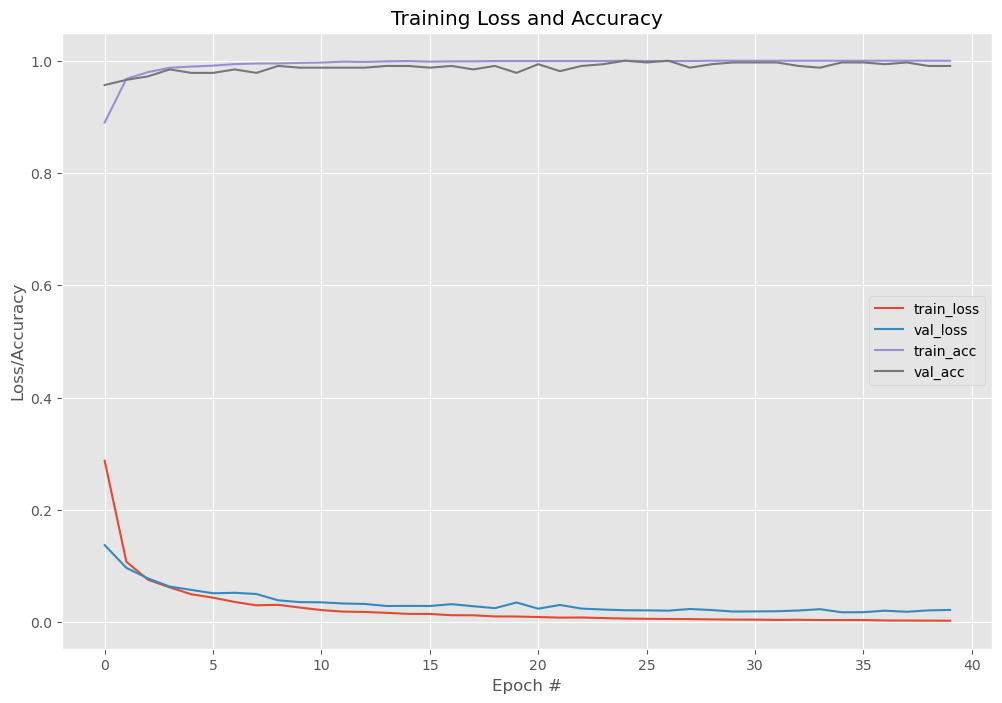

In [58]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12, 8))
plt.plot(np.arange(0, epochs), H_vgg.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), H_vgg.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epochs), H_vgg.history["acc"], label="train_acc")
plt.plot(np.arange(0, epochs), H_vgg.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [59]:
predictions_vgg = model_vgg.predict(X_test,batch_size=128) #(X)
print(predictions_vgg.shape)
print(classification_report(y_test.argmax(axis=1), predictions_vgg.argmax(axis=1),target_names=labels))


3/3 [==============================] - 0s 90ms/step
(380, 3)
                  precision    recall  f1-score   support

     bad_quality       0.99      0.96      0.97       159
empty_background       0.99      1.00      0.99        69
    good_quality       0.97      0.99      0.98       152

        accuracy                           0.98       380
       macro avg       0.98      0.98      0.98       380
    weighted avg       0.98      0.98      0.98       380



In [60]:
# We can save the model for future use
model_vgg.save('./data/models/vgg_tl_96x96.h5')

##### VGG16 + FINE TUNING

With this technique, we try to use the pre-trained weights of the first layers of the network, which are associated to general patterns in images.  
We re-train the last layers, the ones that will fit our particular case.

In [71]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Sequential, layers, Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,BatchNormalization,Dense

#import the selected network, trained with ImageNet 
vgg = VGG16(input_shape=(X_train.shape[1],X_train.shape[1],3), weights='imagenet', include_top=False)
# we unfreeze convolutional blocks for retraining (in this case 3 convolutional layers in the last block)
for layer in vgg.layers:
    if layer.name=='block5_conv1':
        print('Frozen to layer: '+ layer.name)
        break
    layer.trainable=False
# we build our top_model after the last layer
last=vgg.output
x = layers.Flatten()(last)
x= layers.Dense(64, activation='relu')(x)
x= layers.BatchNormalization()(x)
x=layers.Dropout(rate=0.2)(x)
prediction = layers.Dense(3, activation='softmax')(x)
model_vgg_ft = Model(inputs=vgg.input, outputs=prediction)
opt = Adam(learning_rate=0.0001)#small learning rate, because we are using a pretrained network
model_vgg_ft.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['acc'])
epochs=25 #we train for 25 epochs, it is faster and we can see that the accuracy is not improving much after that
H_vgg_ft=model_vgg_ft.fit(X_train, y_train, validation_data=(X_val,y_val),batch_size=20,epochs=epochs,verbose=0)

print(model_vgg_ft.summary())

Frozen to layer: block5_conv1
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  

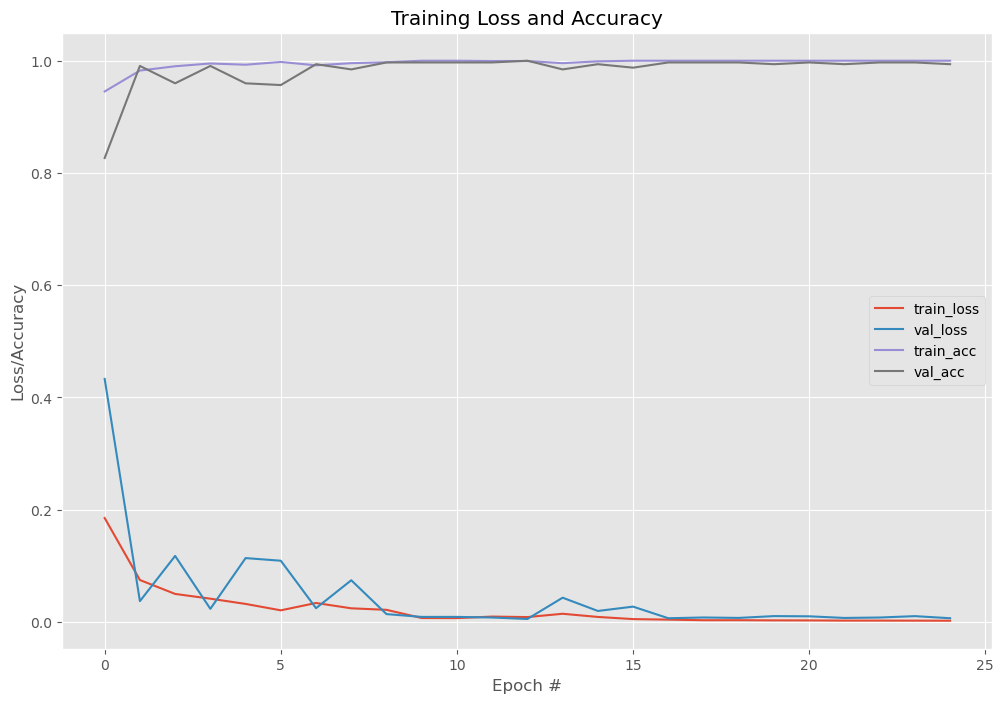

In [72]:
plt.style.use("ggplot")
plt.figure(figsize=(12, 8))
plt.plot(np.arange(0, epochs), H_vgg_ft.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), H_vgg_ft.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epochs), H_vgg_ft.history["acc"], label="train_acc")
plt.plot(np.arange(0, epochs), H_vgg_ft.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()


In [73]:
predictions_vgg_ft = model_vgg_ft.predict(X_test,batch_size=128) #(X)
print(predictions_vgg_ft.shape)
print(classification_report(y_test.argmax(axis=1), predictions_vgg_ft.argmax(axis=1),target_names=labels))


3/3 [==============================] - 0s 96ms/step
(380, 3)
                  precision    recall  f1-score   support

     bad_quality       1.00      1.00      1.00       159
empty_background       1.00      1.00      1.00        69
    good_quality       1.00      1.00      1.00       152

        accuracy                           1.00       380
       macro avg       1.00      1.00      1.00       380
    weighted avg       1.00      1.00      1.00       380



In [74]:
# We can save the model for future use
model_vgg_ft.save('./data/models/vgg_ft_96x96.h5')

#### From MobileNetV2 (transfer learning + fine tuning)

In [76]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Sequential, layers, Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
#import the selected network, trained with ImageNet 
mn = MobileNetV2(input_shape=(X_train.shape[1],X_train.shape[1],3), weights='imagenet', include_top=False)
#we unfreeze convolutional blocks for retraining (in this case 3 last convolutional blocks)
for layer in mn.layers:
    if layer.name=='block_15_expand':
        print('Frozen to the layer: '+ layer.name)
        break
    layer.trainable=False
# we build our top_model after the last layer
last=mn.layers[-1].output
x = layers.Flatten()(last)
x= layers.Dense(64, activation='relu')(x)
x= layers.BatchNormalization()(x)
x=layers.Dropout(rate=0.2)(x)
prediction = layers.Dense(3, activation='softmax')(x)
model_mn = Model(inputs=mn.input, outputs=prediction)
opt = Adam(learning_rate=0.00005) #small learning rate, because we are using a pretrained network
model_mn.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
epochs=25
H_mn=model_mn.fit(X_train, y_train,validation_data=(X_val,y_val),batch_size=20,epochs=epochs,verbose=0)

print(model_mn.summary())

Frozen to the layer: block_15_expand
Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 48, 48, 32)   864         ['input_10[0][0]']               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 48, 48, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 48, 48, 32)   0           ['bn_Conv1[0][0]']               
                                                       

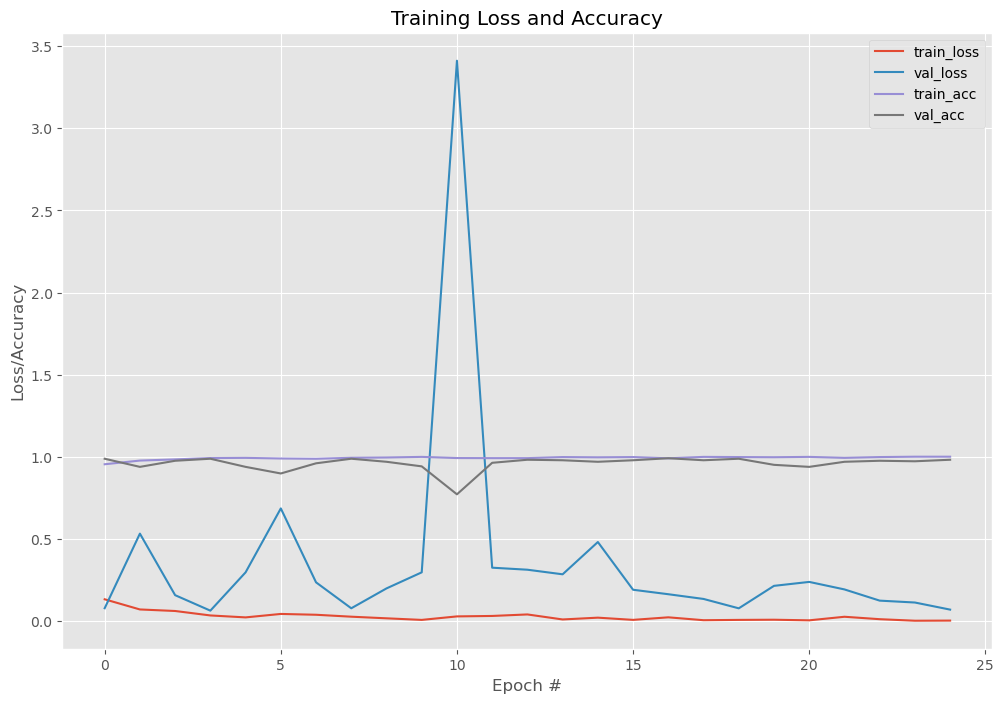

In [77]:
plt.style.use("ggplot")
plt.figure(figsize=(12, 8))
plt.plot(np.arange(0, epochs), H_mn.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), H_mn.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epochs), H_mn.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, epochs), H_mn.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()


In [78]:
predictions_mn = model_mn.predict(X_test,batch_size=128) #(X)
print(predictions_mn.shape)
print(classification_report(y_test.argmax(axis=1), predictions_mn.argmax(axis=1),target_names=labels))


3/3 [==============================] - 2s 143ms/step
(380, 3)
                  precision    recall  f1-score   support

     bad_quality       1.00      0.96      0.98       159
empty_background       1.00      1.00      1.00        69
    good_quality       0.96      1.00      0.98       152

        accuracy                           0.98       380
       macro avg       0.99      0.99      0.99       380
    weighted avg       0.98      0.98      0.98       380



In [79]:
# We can save the model for future use
model_mn.save('./data/models/movileNetV2.h5')

## CONCLUSIONS

Three CNN models have been designed to solve our classification with two different strategies, the first one following a "from scratch" strategy (in which we made the complete design of the network), the second one starting from the pre-trained VGG16 network (testing only transfer learning and also transfer learning+fine tunning) and the third one based on the MobileNetV2 model (also with transfer learning+ fine tunning).    

Different techniques have been used to improve accuracy without overfitting, achieving great results through Batch Normalization and Dropout. Other techniques such as data augmentation have not been applied, since the classification task is simple (good lemons are easily distinguished from poor quality ones) and no overfitting was generated in the models, so we would increase computational time without significantly improving the results.    

All three strategies are quite accurate in classifying the images into the 3 classes, with the optimal one being the pre-trained vgg16 network with the last convolutional layer re-trained (fine tuning), achieving 100% accuracy in the three classes without overfitting.